In [1]:
import requests
from datetime import date
from calendar import monthrange
import os.path

In [2]:
# https://files.airnowtech.org/airnow/2016/20161101/peak_aqi_usa.jpg
image_url_base = "https://files.airnowtech.org/airnow/{}/{}/peak_aqi_usa.jpg"

# note that there's also an API at https://docs.airnowapi.org/
# but they limit their endpoints to 500/day, and the only historical data
# i could find was on a per-day, per-county basis, which makes getting
# all data about a whole state for a whole year basically impossible

In [3]:
def download_aqi_images(numdays, directory):
    s = requests.session()
    base = datetime.datetime.today()
    date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
    for date in date_list:
        ymd = "{}{:02}{:02}".format(date.year, date.month, date.day)
        download_file = "{}/{}.jpg".format(directory, ymd)
        if os.path.isfile(download_file):
            continue
        url = image_url_base.format(date.year, ymd)
        r = s.get(url, stream=True)
        if r.status_code == 200:
            with open(download_file, 'wb') as f:
                for chunk in r:
                    f.write(chunk)

In [4]:
from sklearn.cluster import KMeans

In [5]:
import numpy as np

In [6]:
from scipy import misc
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
img = misc.imread("pm25_images/20160517.jpg")

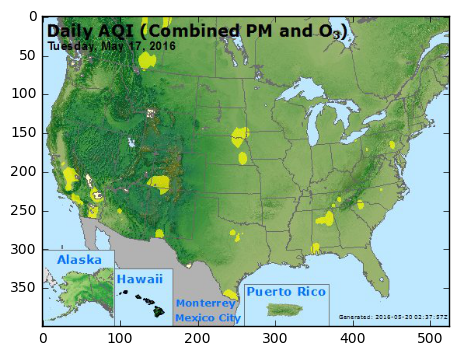

In [8]:
plt.imshow(img)